In [22]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print t

from mpi4py import MPI
from petsc4py import PETSc
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import gmsh
from dolfinx import geometry
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter, gmshio, XDMFFile
from dolfinx.mesh import create_unit_square,create_rectangle, CellType, meshtags, locate_entities_boundary
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional, ge, le)

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.37s/engine]
Stopping engine(s): 1730736179
Output for ipengine-1730736178-hj3v-1730736179-22751:
2024-11-04 17:02:59.526 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-04 17:02:59.526 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-04 17:02:59.533 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-04 17:02:59.533 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-04 17:02:59.534 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-04 17:02:59.534 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-04 17:02:59.547 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-04 17:02:59.547 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-04 17:02:59.574 [IPEngine.2] Registering with control

In [23]:
def run_sim(height=1, length=3,pres=8,T=.5,num_steps=500,r=0, file=False, run=1):
    if run==0:
        mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [length, height]],[int(length*25),int(height*25)])
    if run == 1:
        mesh = create_unit_square(MPI.COMM_WORLD, 100, 100)
    if run == 2:
        mesh, ct, ft, inlet_marker,outlet_marker, upper_wall_marker, lower_wall_marker = create_obst(MPI.COMM_WORLD,height, length, r)
        
    t = 0
    pres = 8 * length
    dt = T / num_steps

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    fdim = mesh.topology.dim - 1

    #mesh.topology.create_entity_permutations()
    #mesh.topology.get_facet_permutations()
    mesh.topology.create_entities(fdim)
    #mesh.topology.create_connectivity(fdim+1, fdim)
    mesh.topology.create_connectivity(fdim, fdim+1)
    """
    # Walls
    #u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    #bcu_walls1 = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(upper_wall_marker)), V)
    #bcu_walls2 = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(lower_wall_marker)), V)
    def walls_u(x):
        return np.isclose(x[1], height)

    def walls_l(x):
        return np.isclose(x[1], 0)
    
    wall_dofs1= locate_dofs_geometrical(V, walls_u)
    wall_dofs2 = locate_dofs_geometrical(V, walls_l)
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bcu_walls1 = dirichletbc(u_noslip, wall_dofs1, V)
    bcu_walls2 = dirichletbc(u_noslip, wall_dofs2, V)
    
    # Outlet
    def outflow(x):
        return np.isclose(x[0], length)
    bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_geometrical(Q, outflow), Q)

    # Inlet
    def inflow(x):
        return np.isclose(x[0], 0)
    bcu_inflow = dirichletbc(PETSc.ScalarType(pres), locate_dofs_geometrical(Q, inflow), Q)
    
    # Obstacle
    if r>0:
        def obstacle(x):
            rc = np.array([length/2,height,0])[:, np.newaxis]
            return np.linalg.norm(x - rc,axis=0) <= r
        #bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V)
        bcu_obstacle = dirichletbc(u_noslip, locate_dofs_geometrical(V, obstacle), V)
        bcu = [bcu_obstacle, bcu_walls1, bcu_walls2]
    else:
        bcu = [bcu_walls1, bcu_walls2]
    bcp = [bcu_inflow, bcp_outlet]
    
    write_x_parview(mesh,ct,ft, "my_mesh")
        
    
    """

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(upper_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V)

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(lower_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip2 = dirichletbc(u_noslip, wall_dofs, V)
    
    inflow_dofs = locate_dofs_topological(Q, fdim, ft.find(inlet_marker))
    bc_inflow = dirichletbc(PETSc.ScalarType(pres), inflow_dofs, Q)
    
    outflow_dofs = locate_dofs_topological(Q, fdim, ft.find(outlet_marker))
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip1, bc_noslip2]
    bcp = [bc_inflow, bc_outflow]

    #write_x_parview(mesh,ct,ft, "my_mesh")
    """
    points = mesh.geometry.x

    # Plot the mesh and boundary regions using matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the full mesh
    for cell in mesh.topology.connectivity(2, 0).array.reshape(-1, 3):
        triangle = points[cell]
        ax.plot(triangle[:, 0], triangle[:, 1], 'k-', linewidth=0.5)
    
    # Plot inflow boundary points
    inflow_points = points[locate_dofs_geometrical(Q, inflow)]
    ax.plot(inflow_points[:, 0], inflow_points[:, 1], 'bo', label="Inflow")
    
    # Plot outflow boundary points
    outflow_points = points[locate_dofs_geometrical(Q, outflow)]
    ax.plot(outflow_points[:, 0], outflow_points[:, 1], 'ro', label="Outflow")
    
    # Plot lower wall points
    lower_wall_points = points[locate_dofs_topological(V, fdim, ft.find(lower_wall_marker))]
    ax.plot(lower_wall_points[:, 0], lower_wall_points[:, 1], 'go', label="Lower Wall")
    
    # Plot upper wall points
    upper_wall_points = points[locate_dofs_topological(V, fdim, ft.find(upper_wall_marker))]
    ax.plot(upper_wall_points[:, 0], upper_wall_points[:, 1], 'mo', label="Upper Wall")
    
    # Add labels, legend and show the plot
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.tight_layout()
    ax.set_title('Mesh with Inflow, Outflow, Lower and Upper Walls')
    ax.legend()
    #ax.set_aspect('equal')
    plt.show()
    """
    # gmsh.clear()
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)

    if file:
        from pathlib import Path
        folder = Path("results")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)
    
    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (1.0 - x[1])
        return values
    
    u_ex = Function(V)
    u_ex.interpolate(u_exact)
    
    L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

    fig, ax = plt.subplots()
    plt.xlabel('y')
    plt.ylabel('u_n')
    plt.title('u_n values at different x-coordinates')
    counter = 0
    for i in range(num_steps):
        # Update current time step
        t += dt
    
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
    
        # print velocity profile
        if (i!=0) and (i % int(num_steps/5) == 0) or (i == num_steps - 1):
            # print(i, u_n.x.array.shape)
            ax = None
            a6, a7 = mfl_press(length, mesh, u_n, p_n)
            #plot_para_velo(ax,mesh, u_n, p_n, t, length, pres, a6, a7)
            # print(a6, a7)
            plot_2dmesh(V, mesh, u_n, c=counter)
            counter+=1

        if file:
            # Write solutions to fileV
            vtx_u.write(t)
            vtx_p.write(t)
    
        # Compute error at current time-step
        error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
        error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
        # Print error only every 20th step and at the last step
        if (i % 20 == 0) or (i == num_steps - 1):
            print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    # Close xmdf file
    if file:
        vtx_u.close()
        vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()
    return u_n, p_n, V, mesh

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Circle)
Info    : Done meshing 1D (Wall 0.000346485s, CPU 0.000501s)
Info    : Meshing 2D...
Info    : Meshing surface 16 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0115809s, CPU 0.011827s)
Info    : 736 nodes 1475 elements
Time 0.00, L2-error 1.16e+00, Max error 3.21e-02
Time 0.06, L2-error 8.77e-01, Max error 1.37e-01
Time 0.12, L2-error 8.06e-01, Max error 1.69e-01
Time 0.18, L2-error 7.88e-01, Max error 1.78e-01
Time 0.24, L2-error 7.83e-01, Max error 1.80e-01
Time 0.30, L2-error 7.81e-01, Max error 1.81e-01
Time 0.36, L2-error 7.81e-01, Max error 1.81e-01
Time 0.42, L2-error 7.81e-01, Max error 1.81e-01
Time 0.48, L2-error 7.81e-01, Max error 1.81e-01
Time 0.54, L2-error 7.81e-01, Max error 1.81e-01


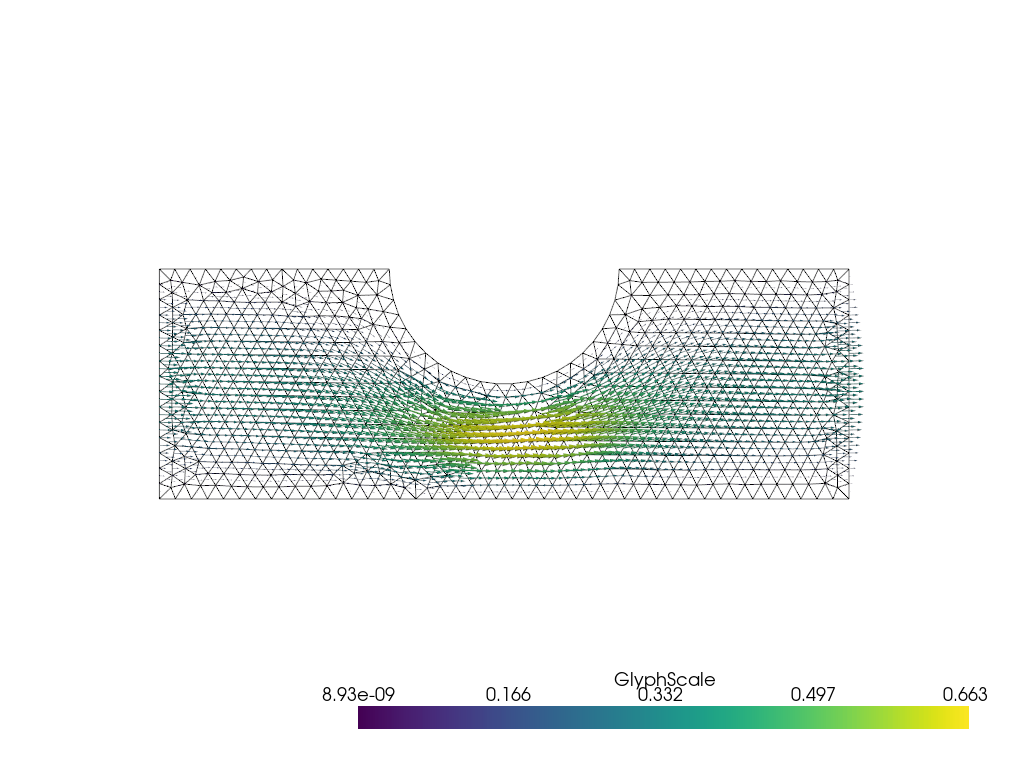

Time 0.60, L2-error 7.81e-01, Max error 1.81e-01
Time 0.66, L2-error 7.81e-01, Max error 1.81e-01
Time 0.72, L2-error 7.81e-01, Max error 1.81e-01
Time 0.78, L2-error 7.81e-01, Max error 1.81e-01
Time 0.84, L2-error 7.81e-01, Max error 1.81e-01
Time 0.90, L2-error 7.81e-01, Max error 1.81e-01
Time 0.96, L2-error 7.81e-01, Max error 1.81e-01
Time 1.02, L2-error 7.81e-01, Max error 1.81e-01
Time 1.08, L2-error 7.81e-01, Max error 1.81e-01
Time 1.14, L2-error 7.81e-01, Max error 1.81e-01


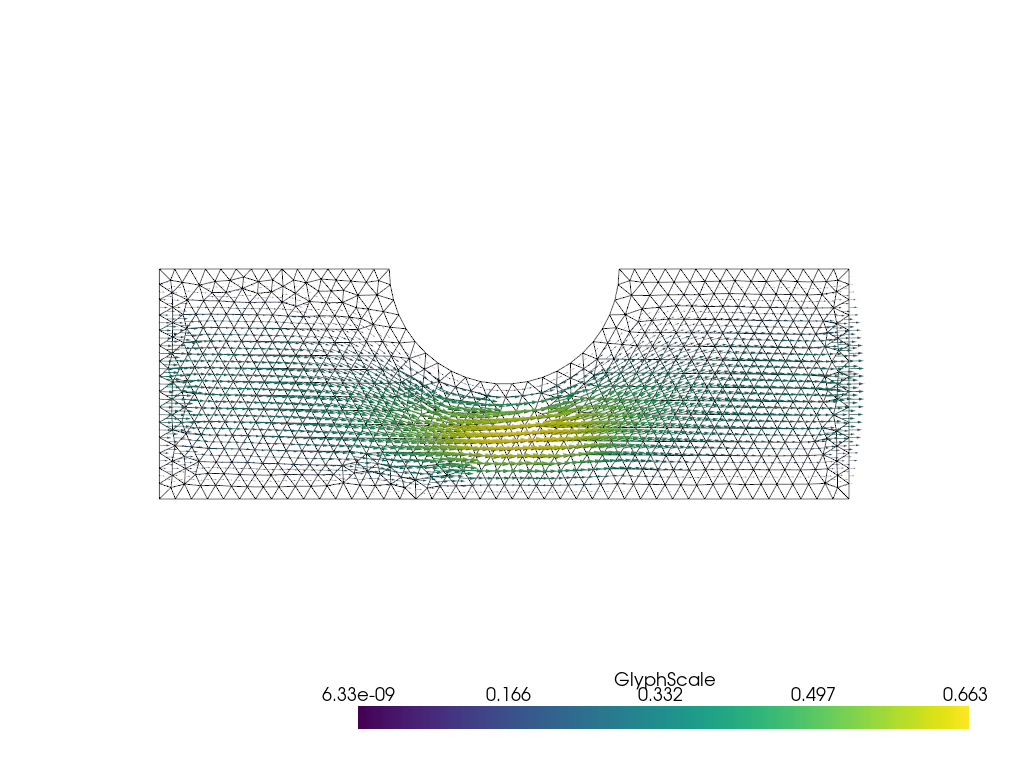

Time 1.20, L2-error 7.81e-01, Max error 1.81e-01
Time 1.26, L2-error 7.81e-01, Max error 1.81e-01
Time 1.32, L2-error 7.81e-01, Max error 1.81e-01
Time 1.38, L2-error 7.81e-01, Max error 1.81e-01
Time 1.44, L2-error 7.81e-01, Max error 1.81e-01
Time 1.50, L2-error 7.81e-01, Max error 1.81e-01
Time 1.56, L2-error 7.81e-01, Max error 1.81e-01
Time 1.62, L2-error 7.81e-01, Max error 1.81e-01
Time 1.68, L2-error 7.81e-01, Max error 1.81e-01
Time 1.74, L2-error 7.81e-01, Max error 1.81e-01


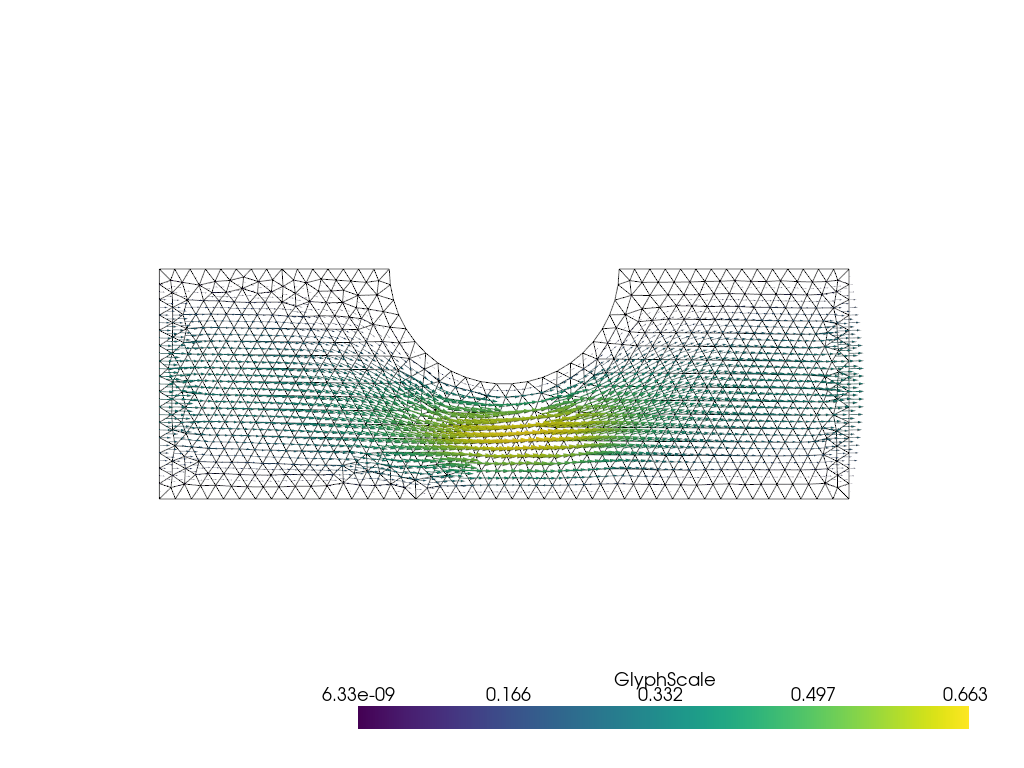

Time 1.80, L2-error 7.81e-01, Max error 1.81e-01
Time 1.86, L2-error 7.81e-01, Max error 1.81e-01
Time 1.92, L2-error 7.81e-01, Max error 1.81e-01
Time 1.98, L2-error 7.81e-01, Max error 1.81e-01
Time 2.04, L2-error 7.81e-01, Max error 1.81e-01
Time 2.10, L2-error 7.81e-01, Max error 1.81e-01
Time 2.16, L2-error 7.81e-01, Max error 1.81e-01
Time 2.22, L2-error 7.81e-01, Max error 1.81e-01
Time 2.28, L2-error 7.81e-01, Max error 1.81e-01
Time 2.34, L2-error 7.81e-01, Max error 1.81e-01


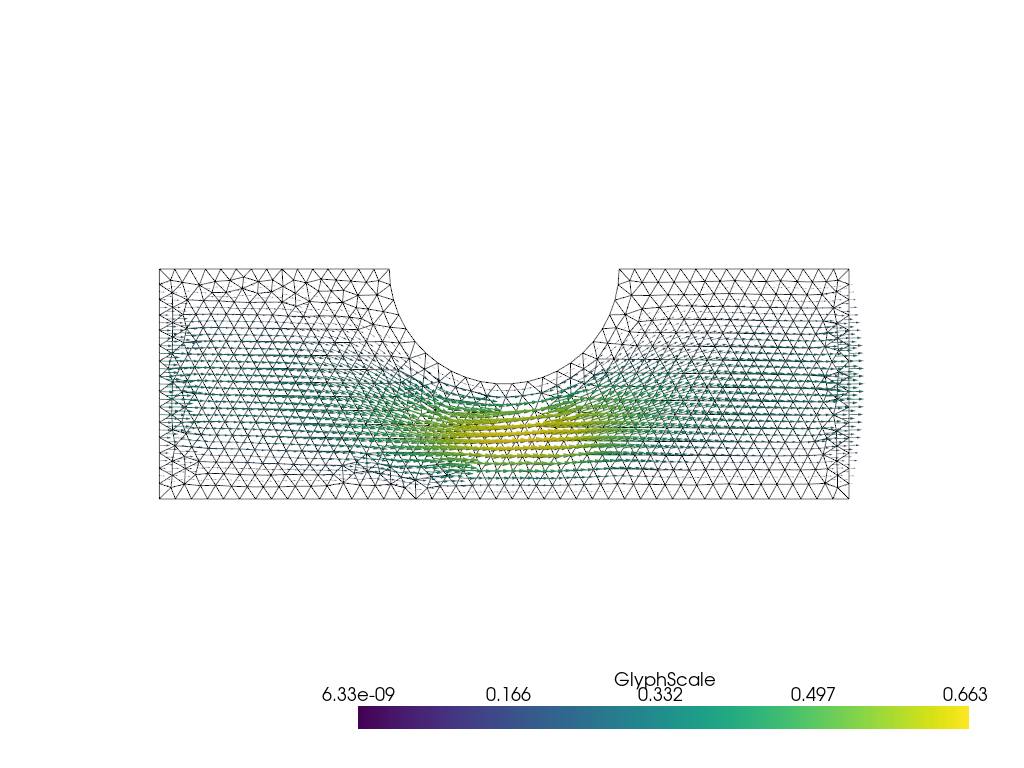

Time 2.40, L2-error 7.81e-01, Max error 1.81e-01
Time 2.46, L2-error 7.81e-01, Max error 1.81e-01
Time 2.52, L2-error 7.81e-01, Max error 1.81e-01
Time 2.58, L2-error 7.81e-01, Max error 1.81e-01
Time 2.64, L2-error 7.81e-01, Max error 1.81e-01
Time 2.70, L2-error 7.81e-01, Max error 1.81e-01
Time 2.76, L2-error 7.81e-01, Max error 1.81e-01
Time 2.82, L2-error 7.81e-01, Max error 1.81e-01
Time 2.88, L2-error 7.81e-01, Max error 1.81e-01
Time 2.94, L2-error 7.81e-01, Max error 1.81e-01


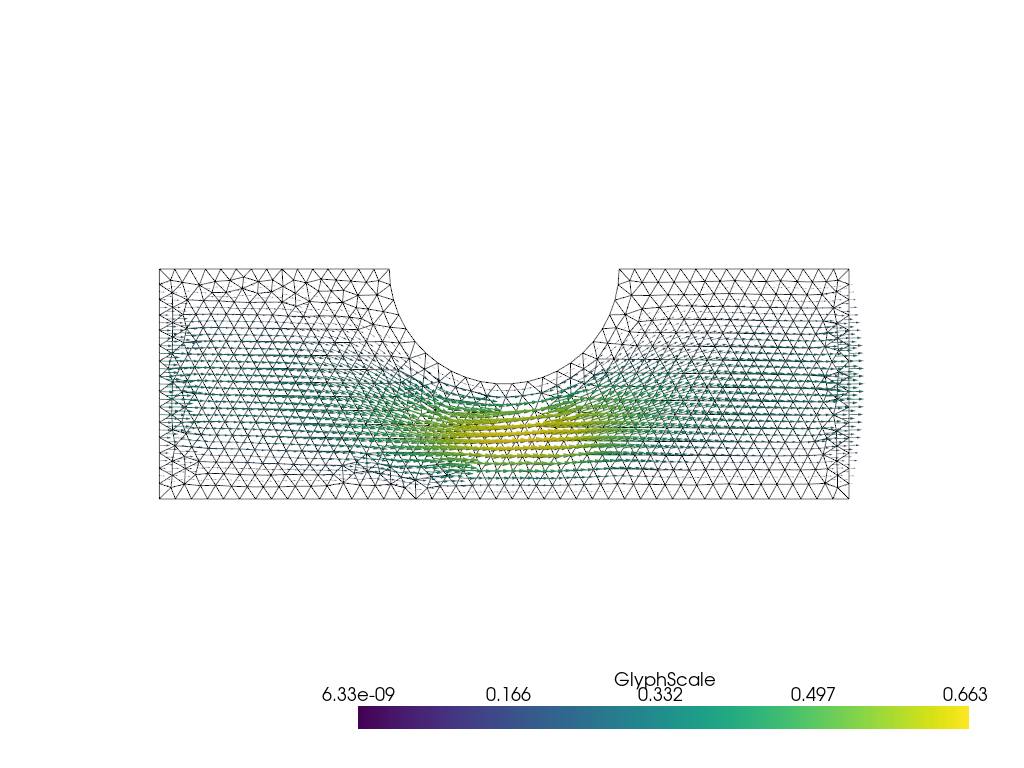

Time 3.00, L2-error 7.81e-01, Max error 1.81e-01


(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 15), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))), 110),
 Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 15), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 111),
 FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 15), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))),
 <dolfinx.mesh.Mesh at 0x7f4eadaf16d0>)

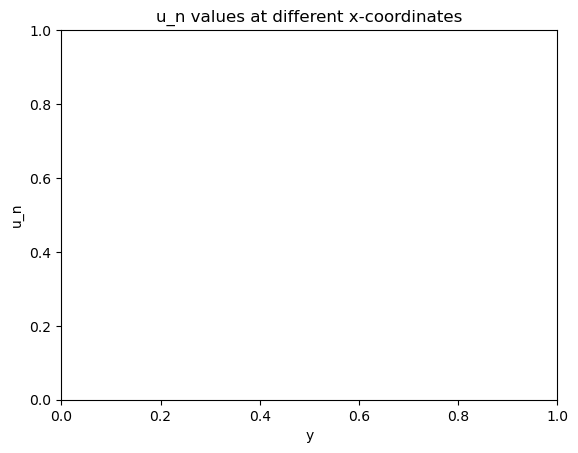

In [38]:
#u_n, p_n, V, mesh = run_sim()
#u_n, p_n, V, mesh = run_sim()
# 0 = canal, 1 = unitcube
#run_sim(.5,4,100,3,1000,False,0)
#run_sim(height=1,length=1,pres=8,T=3,num_steps=1000,file=False,run=0)
run_sim(height=1,length=3,pres=8,T=3,num_steps=1000,r=.5,file=False,run=2)
#run_sim()
#run_sim(height=1,length=4,pres=8,T=1,num_steps=1000,file=False,run=2)

Info    : Meshing 1D...ence                                                                                                          
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Ellipse)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000439936s, CPU 0.000553s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, MeshAdapt)
Info    : Done meshing 2D (Wall 0.00372748s, CPU 0.003277s)
Info    : 118 nodes 240 elements
Time 0.00, L2-error 1.24e+00, Max error 8.85e-03
Time 0.02, L2-error 1.00e+00, Max error 1.68e-01
Time 0.04, L2-error 7.77e-01, Max error 3.28e-01
Time 0.06, L2-error 5.96e-01, Max error 4.88e-01
Time 0.08, L2-error 5.03e-01, Max error 6.48e-01
Time 0.10, L2-error 5.46e-01, Max error 8.08e-01
Time 0.12, L2-error 7.00e-01, Max error 9.68e-01
Time 0.14, L2-error 9.10e-01, Max error 1.13e+00
Time 0

Widget(value='<iframe src="http://localhost:39289/index.html?ui=P_0x7fa45c718050_0&reconnect=auto" class="pyvi…

Time 0.20, L2-error 1.65e+00, Max error 1.61e+00
Time 0.22, L2-error 1.91e+00, Max error 1.77e+00
Time 0.24, L2-error 2.17e+00, Max error 1.93e+00
Time 0.26, L2-error 2.44e+00, Max error 2.09e+00
Time 0.28, L2-error 2.70e+00, Max error 2.25e+00
Time 0.30, L2-error 2.97e+00, Max error 2.41e+00
Time 0.32, L2-error 3.24e+00, Max error 2.57e+00
Time 0.34, L2-error 3.51e+00, Max error 2.73e+00
Time 0.36, L2-error 3.77e+00, Max error 2.89e+00
Time 0.38, L2-error 4.04e+00, Max error 3.05e+00


Widget(value='<iframe src="http://localhost:39289/index.html?ui=P_0x7fa40e3c42c0_1&reconnect=auto" class="pyvi…

Time 0.40, L2-error 4.31e+00, Max error 3.21e+00
Time 0.42, L2-error 4.58e+00, Max error 3.37e+00
Time 0.44, L2-error 4.85e+00, Max error 3.53e+00
Time 0.46, L2-error 5.12e+00, Max error 3.69e+00
Time 0.48, L2-error 5.39e+00, Max error 3.85e+00
Time 0.50, L2-error 5.66e+00, Max error 4.01e+00
Time 0.52, L2-error 5.93e+00, Max error 4.17e+00
Time 0.54, L2-error 6.20e+00, Max error 4.33e+00
Time 0.56, L2-error 6.47e+00, Max error 4.49e+00
Time 0.58, L2-error 6.74e+00, Max error 4.65e+00


Widget(value='<iframe src="http://localhost:39289/index.html?ui=P_0x7fa40cf248f0_2&reconnect=auto" class="pyvi…

Time 0.60, L2-error 7.01e+00, Max error 4.81e+00
Time 0.62, L2-error 7.28e+00, Max error 4.97e+00
Time 0.64, L2-error 7.55e+00, Max error 5.13e+00
Time 0.66, L2-error 7.82e+00, Max error 5.29e+00
Time 0.68, L2-error 8.09e+00, Max error 5.45e+00
Time 0.70, L2-error 8.36e+00, Max error 5.61e+00
Time 0.72, L2-error 8.63e+00, Max error 5.77e+00
Time 0.74, L2-error 8.90e+00, Max error 5.93e+00
Time 0.76, L2-error 9.17e+00, Max error 6.09e+00
Time 0.78, L2-error 9.44e+00, Max error 6.25e+00


Widget(value='<iframe src="http://localhost:39289/index.html?ui=P_0x7fa41b3a32c0_3&reconnect=auto" class="pyvi…

Time 0.80, L2-error 9.71e+00, Max error 6.41e+00
Time 0.82, L2-error 9.98e+00, Max error 6.57e+00
Time 0.84, L2-error 1.03e+01, Max error 6.73e+00
Time 0.86, L2-error 1.05e+01, Max error 6.89e+00
Time 0.88, L2-error 1.08e+01, Max error 7.05e+00
Time 0.90, L2-error 1.11e+01, Max error 7.21e+00
Time 0.92, L2-error 1.13e+01, Max error 7.37e+00
Time 0.94, L2-error 1.16e+01, Max error 7.53e+00
Time 0.96, L2-error 1.19e+01, Max error 7.69e+00
Time 0.98, L2-error 1.21e+01, Max error 7.85e+00


Widget(value='<iframe src="http://localhost:39289/index.html?ui=P_0x7fa3f8d0a2a0_4&reconnect=auto" class="pyvi…

Time 1.00, L2-error 1.24e+01, Max error 8.00e+00


(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 2), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))), 0),
 Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 2), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 1),
 FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 2), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))),
 <dolfinx.mesh.Mesh at 0x7fa41b39e660>)

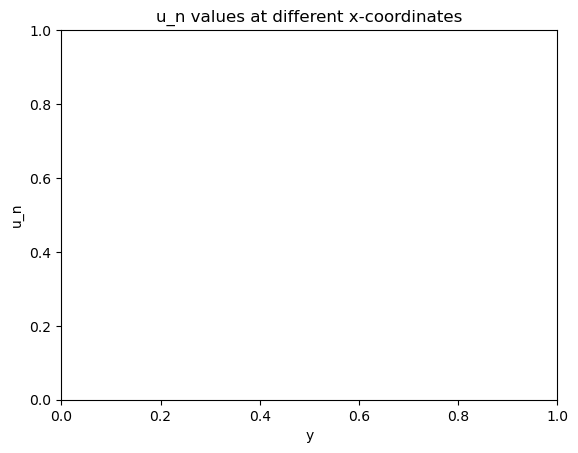

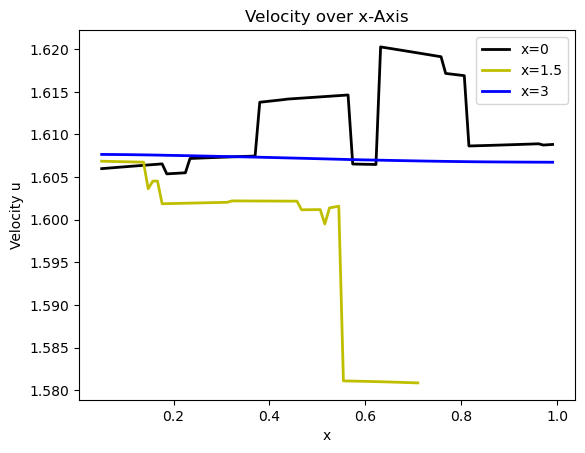

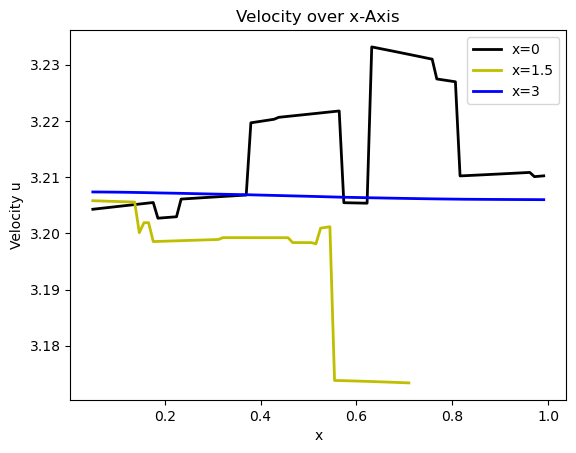

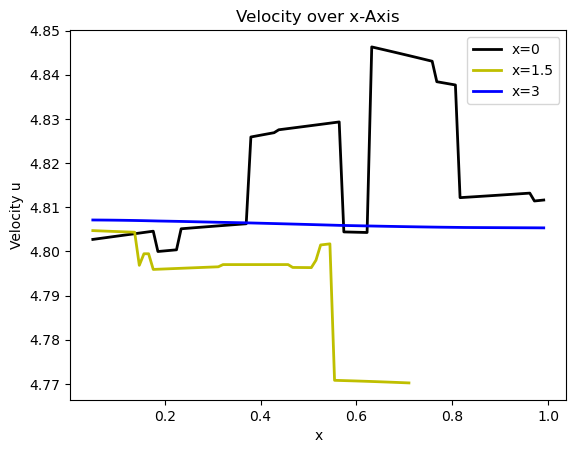

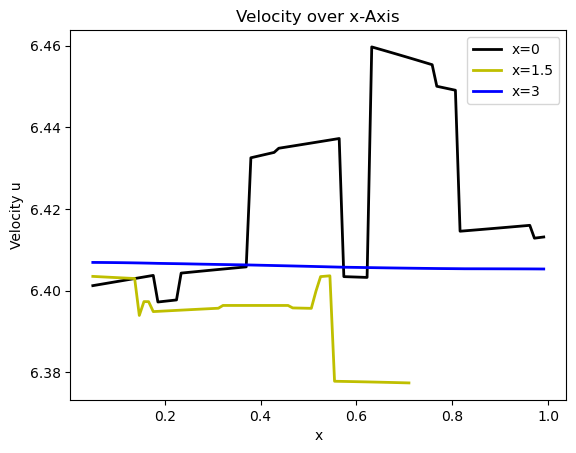

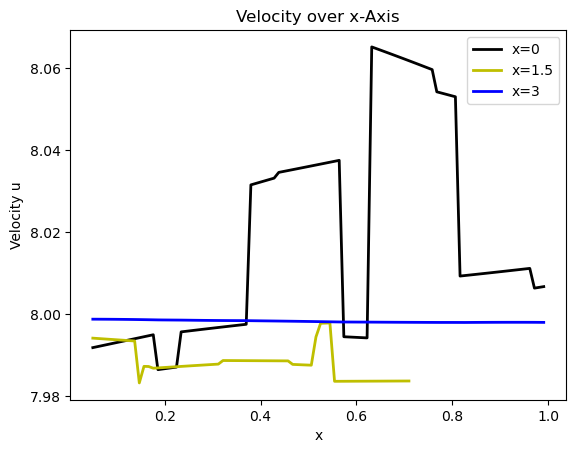

In [9]:
run_sim(height=1,length=3,pres=8,T=1,num_steps=1000,r=0,file=False,run=2)

In [ ]:
run_sim(height=1,length=8,pres=64,T=3,num_steps=1000,file=False,run=0)

In [26]:
#run_sim(height=1,length=16,pres=128,T=3,num_steps=1000,file=False,run=0)
mesh = run_sim(height=1,length=3,pres=8,T=1,num_steps=1000,r=0.5,file=False,run=2)

Info    : Meshing 1D...ence                                                                                                          
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Ellipse)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.00060595s, CPU 0.000691s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, MeshAdapt)
Info    : Done meshing 2D (Wall 0.00316336s, CPU 0.00344s)
Info    : 108 nodes 220 elements


In [27]:
positions = mesh.geometry.x[:,:-1]
x = positions[:,0]
y = positions[:,1]

In [37]:
rc = np.array([1.5,1.0])
mask_circle = np.linalg.norm(positions - rc,axis=1) <= 0.5

In [28]:
mask_top = np.isclose(y,1.0)

In [ ]:
plt.scatter(x,y)
plt.scatter(x[mask_top],y[mask_top],c='r')
plt.scatter(x[mask_circle],y[mask_circle],c='r')

In [12]:
# Get mass flow and pressure
def mfl_press(x_max, mesh, u_n, p):
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)

    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    x_pos = int(x_max/2)

    slice_condition = conditional(ge(x[0], x_pos - 5e-1), 1.0, 0.0) * conditional(le(x[0], x_pos + 5e-1), 1.0, 0.0)
    # Calculate mass flow rate at the current slice
    mass_flow = assemble_scalar(form(u_sub * slice_condition * dx))
    # Calculate average pressure at the current slice
    #pressure_avg = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx))
    pressure_avg = 0
    return mass_flow, pressure_avg

def write_x_parview(msh,ct,ft, name):
    with XDMFFile(msh.comm, f"out_gmsh/mesh_rank_{MPI.COMM_WORLD.rank}.xdmf", "w") as file:
        msh.topology.create_connectivity(1, 2)
        file.write_mesh(msh)
        file.write_meshtags(ct, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{name}_ct']/Geometry")
        file.write_meshtags(ft, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{name}_ft']/Geometry")

def plot_para_velo(ax,mesh, u_n,p_n, t, length, pres, a6, a7):
    if MPI.COMM_WORLD.rank == 0:
        fig, ax = plt.subplots()
        plt.xlabel('y')
        plt.ylabel('u_n')
        plt.title('u_n values at different x-coordinates')
        tol = 0.05  # Avoid hitting the outside of the domain
        y = np.linspace(0, length, int(length/0.07))
        #x = np.linspace(0+tol, length-tol, int(length*100))
        points = np.zeros((3, int(length/0.07)))
        points[1] = y
        points[0] = 0
        
        bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
        cells, cells1, cells2, p_o_p, p_o_p1, p_o_p2 = [], [], [], [], [], []
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                p_o_p.append(point)
                cells.append(colliding_cells.links(i)[0])
        
        points[0] = length/2
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                p_o_p1.append(point)
                cells1.append(colliding_cells.links(i)[0])
        
        points[0] = length-tol
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                p_o_p2.append(point)
                cells2.append(colliding_cells.links(i)[0])
        
        p_o_p = np.array(p_o_p, dtype=np.float64)
        u_values = u_n.eval(p_o_p, cells)
        p_values = p_n.eval(p_o_p, cells)
        
        p_o_p1 = np.array(p_o_p1, dtype=np.float64)
        u_values1 = u_n.eval(p_o_p1, cells1)
        p_values1 = p_n.eval(p_o_p1, cells1)
        
        p_o_p2 = np.array(p_o_p2, dtype=np.float64)
        u_values2 = u_n.eval(p_o_p2, cells2)
        p_values2 = p_n.eval(p_o_p2, cells2)
        plt.title("Velocity over x-Axis")
        #plt.plot(p_o_p[:, 1], u_values[:,0], "k", linewidth=2, label="x=0")
        #plt.plot(p_o_p1[:, 1], u_values1[:,0], "y", linewidth=2, label=r"x=%s"%(length/2))
        plt.plot(p_o_p2[:, 1], u_values2[:,0], "b", linewidth=2, label=r"x=%s"%(length))
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("Velocity u")
        # If run in parallel as a python file, we save a plot per processor
        plt.savefig(f"para_plot/u_n_p_canal_test")#{int(pres):d}_{int(t*100):d}.pdf") #25_{int(pres):d}_{int(t*100):d}.pdf")

def plot_2dmesh(V, mesh, u_n, c):
    #pyvista.start_xvfb()
    topology, cell_types, geo = vtk_mesh(V)
    values = np.zeros((geo.shape[0], 3), dtype=np.float64)
    values[:, :len(u_n)] = u_n.x.array.real.reshape((geo.shape[0], len(u_n)))
    
    # Create a point cloud of glyphs
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geo)
    function_grid["u"] = values
    glyphs = function_grid.glyph(orient="u", factor=0.2)
    
    # Create a pyvista-grid for the mesh
    grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))
    
    # Create plotter
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, style="wireframe", color="k")
    plotter.add_mesh(glyphs)
    plotter.view_xy()
    if not pyvista.OFF_SCREEN:
        plotter.show()
        plotter.screenshot(f"canal_{c:d}.png")
    else:
        #f"para_plot/u_n_p_canal_test")#{int(pres):d}
        fig_as_array = plotter.screenshot(f"glyphs_{c:d}.png")

In [32]:
def create_obst(comm,H=1, L=3,r=.3, lc=.07):
    model_rank = 0
    if comm.rank == model_rank:
        gmsh.initialize()
        gmsh.model.add("canal")
        
        cm = 1 # e-02 # not needed for our sim
        h1 = H * cm
        l1 = L * cm
        r = r * cm
        Lc1 = lc
        
        # We start by defining some points and some lines. To make the code shorter we
        # can redefine a namespace:
        factory = gmsh.model.geo
        model = gmsh.model
        
        factory.addPoint(0, 0, 0, Lc1, 1)
        factory.addPoint(l1, 0, 0, Lc1, 2)
        factory.addPoint(l1, h1 , 0, Lc1, 3)
        factory.addPoint(0, h1, 0, Lc1, 4)
        
        factory.addPoint(l1/2-r, h1, 0, Lc1, 5)
        factory.addPoint(l1/2, h1, 0, Lc1, 6)
        factory.addPoint(l1/2+r, h1, 0, Lc1, 7)
        
        factory.addLine(1, 2, 8)
        factory.addLine(2, 3, 9)
        factory.addLine(3, 7, 10)
        factory.addLine(5, 4, 11)
        factory.addLine(4, 1, 12)
        
        factory.addCircleArc(5, 6, 7, 13)
        
        # Define the inner curve loop (the circle arc)
        factory.addCurveLoop([-13], 14)
        
        # Define the outer curve loop
        factory.addCurveLoop([8, 9, 10, -13, 11, 12], 15)
        
        # Create the plane surface with a hole
        factory.addPlaneSurface([15], 16)
        factory.synchronize()
        
        upper = model.addPhysicalGroup(1, [10, -13, 11])
        model.setPhysicalName(1, upper, "upper_wall")
        outfl = model.addPhysicalGroup(1, [9])
        model.setPhysicalName(1, outfl, "outflow")
        infl = model.addPhysicalGroup(1, [12])
        model.setPhysicalName(1, infl, "inflow")
        lower = model.addPhysicalGroup(1, [8])
        model.setPhysicalName(1, lower, "lower_wall")

        gmsh.model.addPhysicalGroup(2, [16], tag=5, name="Domain")
        factory.synchronize()
        gmsh.model.mesh.generate(2)
        #gmsh.finalize()   
        mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, comm, model_rank,gdim=2)
        return mesh, ct, ft, infl, outfl, upper, lower


In [22]:
import dtoolcore
import dtoolcore.utils as utils
import time
import numpy as np

In [4]:
# Function to save NumPy array and add it to the dataset
def save_numpy_array(array, name, folder):
    file_path = os.path.join(folder, name)
    np.savetxt(file_path, array, fmt='%.10e')
    # dataset.put_item(file_path, name)
    return file_path

def store_xy_arrays(arr, t, dataset_name, db):
    """
    Store x and y numpy arrays in a dtool dataset.
    
    Parameters:
    arr (numpy.ndarray): 3D numpy array of x, y values (Velocity)
    t (numpy.ndarray): 1D numpy array of Tima values 
    dataset_name (str): Name for the dtool dataset
    output_path (str): Path to store the dataset
    """
    
    # use epoch for identification
    epoch = time.time()
    count = 0
    for x,y in res:
        fpath = db+"/"+dataset_name+"_"+str(epoch)+"/data/"+str(t[count])+"/"
        utils.mkdir_parents(fpath)
        for x,y in res:
            np.savetxt(fpath+"x.txt", x, fmt='%.10e')
            np.savetxt(fpath+"y.txt", y, fmt='%.10e')
            count+=1
    
    # Freeze the dataset
    dataset.freeze()
    
    print(f"Dataset '{dataset_name}' created at {output_path}")

# Example usage
s = np.arange(0,100,.33)
epoch = time.time()
res = np.array( [[s,s],[s,s],[s,s]] )
t = np.array([1,2,3])

store_xy_arrays(xy,t, "sine_wave", "dtool_db")

AttributeError: 'DataSetCreator' object has no attribute 'prepare_staging_area_item'

In [35]:
s = np.arange(0,100,.33)
epoch = time.time()
res = np.array( [[s,s],[s,s],[s,s]] )
t = np.array([1,2,3])

def save_numpy_array(array, file_path):
    np.savetxt(file_path, array, fmt='%.10e')
    # dataset.put_item(file_path, name)

dataset = dtoolcore.create_proto_dataset("run_" + str(epoch), "dtool_db")

#{"description": "Raw data files for plots"})
#ds_creator.put_annotation(folders[0], {"description": "Source for x, y coordinates of different "})
# {"description": "Fedotov Ilia - bsc data, dolfinx results"})
#utils.mkdir_parents("dtool_db/run"+str(epoch)+"/"+folders[0] )
count = 0
for x,y in res:
    utils.mkdir_parents("dtool_db/run_"+str(epoch)+"/data/"+str(t[0])+"/" )
    for x,y in res:
        save_numpy_array(x,"dtool_db/run_"+str(epoch)+"/data/"+str(t[0])+"/x.txt")
        save_numpy_array(y,"dtool_db/run_"+str(epoch)+"/data/"+str(t[0])+"/y.txt")
        count+=1

#res.shape

Type:        ProtoDataSet
String form: <dtoolcore.ProtoDataSet object at 0x7fb21132c110>
File:        ~/.local/lib/python3.12/site-packages/dtoolcore/__init__.py
Docstring:   Class for building up a dataset.

In [26]:
dtoolcore.create_proto_dataset?

Signature:
dtoolcore.create_proto_dataset(
    name,
    base_uri,
    readme_content='',
    creator_username=None,
)
Docstring:
Return :class:`dtoolcore.ProtoDataSet` instance.

:param name: dataset name
:param base_uri: base URI for proto dataset
:param readme_content: content of README as a string
:param creator_username: creator username
File:      ~/.local/lib/python3.12/site-packages/dtoolcore/__init__.py
Type:      function